In [1]:
import sys
from pathlib import Path

# Project root (one level ABOVE src)
PROJ_ROOT = Path(r"C:\Users\quantbase\Desktop\SyStrat_factmod")

if str(PROJ_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJ_ROOT))

print("Project root on sys.path:", PROJ_ROOT in map(Path, map(str, sys.path)))

from src.fm_config import DATA_INT
print("DATA_INT =", DATA_INT)


Project root on sys.path: True
DATA_INT = C:\Users\quantbase\Desktop\SyStrat_factmod\data_int


In [2]:
import sys
from pathlib import Path

import numpy as np      # already in env — no new install
import pandas as pd     # already in env — no new install
import matplotlib.pyplot as plt  # already in env — no new install

# Project root and src import
REPO = Path(r"C:\Users\quantbase\Desktop\SyStrat_factmod")
if str(REPO) not in sys.path:
    sys.path.insert(0, str(REPO))

from src.fm_config import DATA_INT   # no installation needed

pd.set_option("display.max_columns", None)


In [3]:
from src.fm_config import DATA_INT            # no installation needed
from src.fm_alpha_us import STYLE_COLS        # no installation needed
DATA_INT

WindowsPath('C:/Users/quantbase/Desktop/SyStrat_factmod/data_int')

In [4]:
# 1. Load core panels



# Style factors (already z-scored cross-sectionally per date)
style = pd.read_parquet(DATA_INT / "style_us_full.parquet")
style["date"] = pd.to_datetime(style["date"])

# Alpha panel: μ_factor, α_resid, σ, *_lambda
alpha_panel = pd.read_parquet(DATA_INT / "alpha_panel_us.parquet")
alpha_panel["date"] = pd.to_datetime(alpha_panel["date"])

# Scores: S_long, ranks, weights, sector, etc.
scores = pd.read_parquet(DATA_INT / "scores_us.parquet")
scores["date"] = pd.to_datetime(scores["date"])

# Work on latest date in scores
latest_date = scores["date"].max()
latest_date


Timestamp('2024-11-21 00:00:00')

In [5]:
# 2. Cross-sectional factor z-scores on the pitch date


factor_cols = ["SIZE", "VAL", "MOM", "QUAL", "EMA20_GAP", "VOL_Z", "LIQ"]

style_last = (
    style[style["date"] == latest_date]
    .sort_values("ticker")
    .reset_index(drop=True)
)

# Table: standardized factor scores for the whole universe on that date
style_last[["ticker"] + factor_cols].head(20)


,ticker,SIZE,VAL,MOM,QUAL,EMA20_GAP,VOL_Z,LIQ
0,AAPL,2.488422,-0.623958,-0.541167,0.949102,-0.235793,-0.586681,1.332143
1,ABBV,-0.290570,-0.579288,-0.233342,1.286351,-1.535781,0.342557,-0.227471
2,ABT,-0.747854,0.089343,-0.700966,-0.206786,-0.145366,-0.752446,-0.406032
3,AMAT,-1.135345,0.727977,-0.521996,0.234795,-1.134543,1.312723,-0.000702
4,AMD,-0.642021,-0.797719,-0.417786,-1.463764,-1.522116,1.268114,1.021078
5,AMZN,1.912100,-0.078934,-0.284661,-0.098718,-0.666350,0.107778,1.612937
6,AVGO,0.766940,-1.060085,0.839106,-0.465394,-1.430906,1.185900,0.878786
7,AXP,-0.731011,NaN,0.836918,NaN,0.472375,-0.093249,-1.123990
8,BAC,-0.106608,NaN,0.154104,NaN,0.587791,-0.124551,1.395569
9,CAT,-0.837140,0.953046,0.375262,0.295716,-0.248157,0.237514,-1.358893


<Figure size 640x480 with 0 Axes>

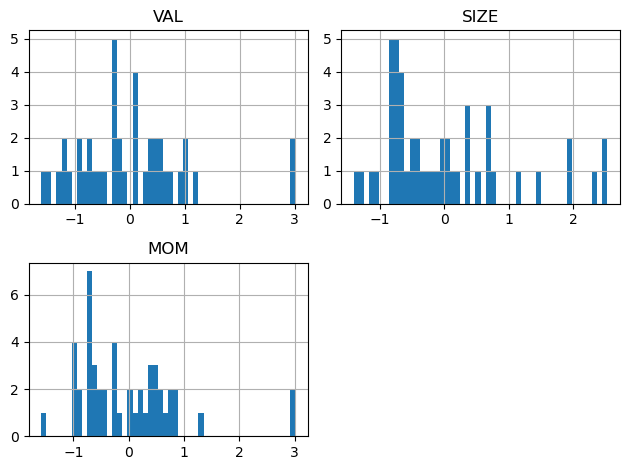

In [16]:
style_last[factor_cols].describe().T

plt.figure()
style_last[["VAL", "SIZE", "MOM"]].hist(bins=50)
plt.axvline(0.0, linestyle="--")
plt.title(f"VAL z-scores (cross-section) on {latest_date.date()}")
plt.xlabel("VAL z-score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Style Factor Premia (Lambdas) on 2024-11-21'}, xlabel='Style Factor', ylabel='Lambda Value'>

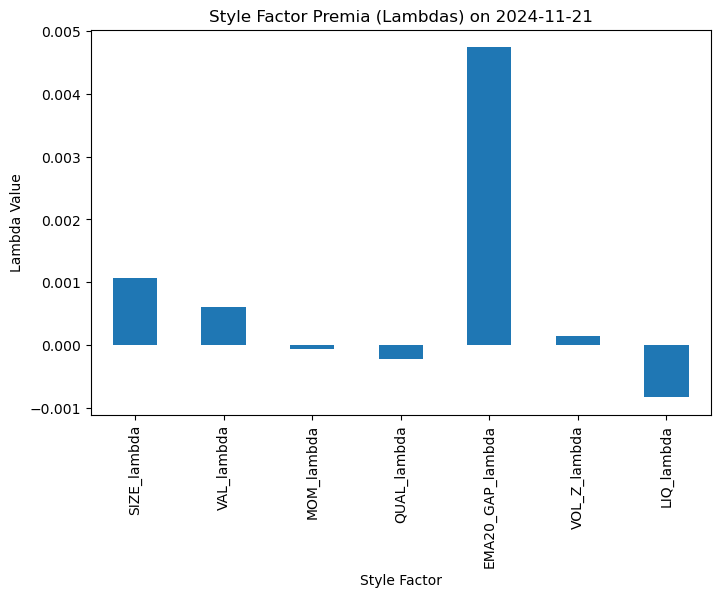

In [27]:
# 3. Factor premia snapshot (lambda’s)


alpha_last = alpha_panel[alpha_panel["date"] == latest_date].copy()

lambda_cols = [f"{c}_lambda" for c in STYLE_COLS]

# One row per date – lambdas are common across tickers
lambda_snapshot = (
    alpha_last[["date"] + lambda_cols]
    .drop_duplicates(subset=["date"])
    .set_index("date")
    .T
)

lambda_snapshot
lambda_snapshot.plot(
    kind="bar",
    legend=False,
    title=f"Style Factor Premia (Lambdas) on {latest_date.date()}",
    ylabel="Lambda Value",
    xlabel="Style Factor",
    figsize=(8, 5),
)

In [28]:
# 4. Universe-level μ_factor, α_resid, σ and scores

scores_last = scores[scores["date"] == latest_date].copy()

cols_summary = [
    "ticker",
    "mu_factor", "mu_factor_z",
    "alpha_resid", "alpha_resid_z",
    "sigma", "sigma_z",
    "S_long", "rank_long", "rank_short",
]

scores_last[cols_summary].sort_values("rank_long").head(15)



,ticker,mu_factor,mu_factor_z,alpha_resid,alpha_resid_z,sigma,sigma_z,S_long,rank_long,rank_short
48944,NFLX,0.010621,2.304761,0.000056,-0.086985,0.020105,0.258939,2.088306,1.0,41.0
48931,ISRG,0.003529,0.765227,0.001686,0.922935,0.017337,-0.065625,1.720974,2.0,40.0
48948,PG,0.001536,0.332621,0.001521,0.820934,0.009690,-0.962440,1.634774,3.0,39.0
48922,COST,0.004207,0.912502,0.000702,0.313268,0.011448,-0.756348,1.603945,4.0,38.0
48940,MRK,-0.003415,-0.741952,0.003385,1.975622,0.011596,-0.738969,1.603155,5.0,37.0
48914,ABT,-0.001113,-0.242282,0.002178,1.228058,0.011413,-0.760409,1.365981,6.0,36.0
48955,UNH,0.001369,0.296326,0.001822,1.007540,0.017223,-0.079046,1.343390,7.0,35.0
48923,CRM,0.004944,1.072366,0.000290,0.057907,0.017237,-0.077412,1.168979,8.0,34.0
48958,WMT,0.004187,0.908140,-0.000108,-0.188134,0.010286,-0.892531,1.166272,9.0,33.0
48930,IBM,0.002665,0.577630,0.000697,0.310375,0.014671,-0.378281,1.077146,10.0,32.0


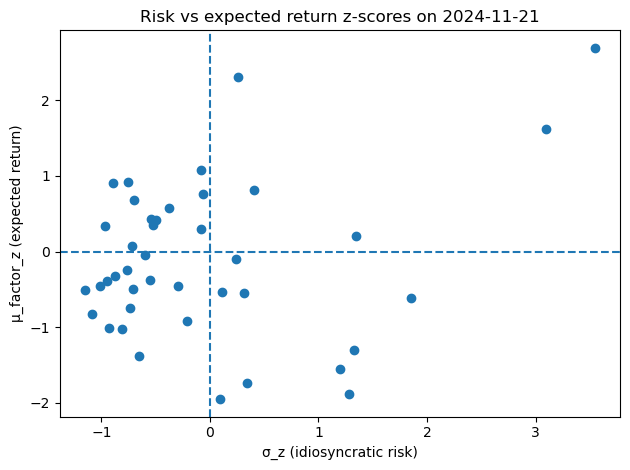

In [29]:
# 4.i. joint view of μ_factor_z vs σ_z, with the “efficient quadrant” where your best longs live.

plt.figure()
plt.scatter(scores_last["sigma_z"], scores_last["mu_factor_z"])
plt.axhline(0.0, linestyle="--")
plt.axvline(0.0, linestyle="--")
plt.xlabel("σ_z (idiosyncratic risk)")
plt.ylabel("μ_factor_z (expected return)")
plt.title(f"Risk vs expected return z-scores on {latest_date.date()}")
plt.tight_layout()
plt.show()

In [32]:
# 5. NFLX snapshot: universe position, score, weight


TICKER = "NFLX"

n_universe = len(scores_last)

row = scores_last[scores_last["ticker"] == TICKER].iloc[0]

print(f"Date       : {row['date'].date()}")
print(f"Ticker     : {row['ticker']}")
print(f"Sector     : {row.get('sector', '<no sector column>')}")
print(f"Market cap : {row['mkt_cap']:.0f} USD")
print(f"Rank_long  : {int(row['rank_long'])} / {n_universe}")
print(f"S_long     : {row['S_long']:.3f}")
print(f"Weight_long: {row.get('weight_long', np.nan):.4f}")



Date       : 2024-11-21
Ticker     : NFLX
Sector     : Communication Services
Market cap : 383635108153 USD
Rank_long  : 1 / 41
S_long     : 2.088
Weight_long: nan


In [ ]:
# 6. NFLX expected return and risk metrics

print("μ_factor    :", f"{row['mu_factor']*100:.3f} %")
print("μ_factor_z  :", f"{row['mu_factor_z']:.2f}")

print("α_resid     :", f"{row['alpha_resid']*100:.3f} %")
print("α_resid_z   :", f"{row['alpha_resid_z']:.2f}")

print("σ (idio)    :", f"{row['sigma']*100:.3f} %")
print("σ_z         :", f"{row['sigma_z']:.2f}")


μ_factor    : 1.062 %
μ_factor_z  : 2.30
α_resid     : 0.006 %
α_resid_z   : -0.09
σ (idio)    : 2.010 %
σ_z         : 0.26


In [34]:
# 7. NFLX factor shape (SIZE, VAL, MOM, QUAL, TECH, VOL, LIQ)


factor_cols_ordered = ["SIZE", "VAL", "MOM", "QUAL", "EMA20_GAP", "VOL_Z", "LIQ"]

exposures = row[factor_cols_ordered]
exposures

SIZE        -0.022729
VAL         -0.908427
MOM          0.748138
QUAL        -0.952108
EMA20_GAP    2.217435
VOL_Z        0.256228
LIQ          -0.58582
Name: 48944, dtype: object

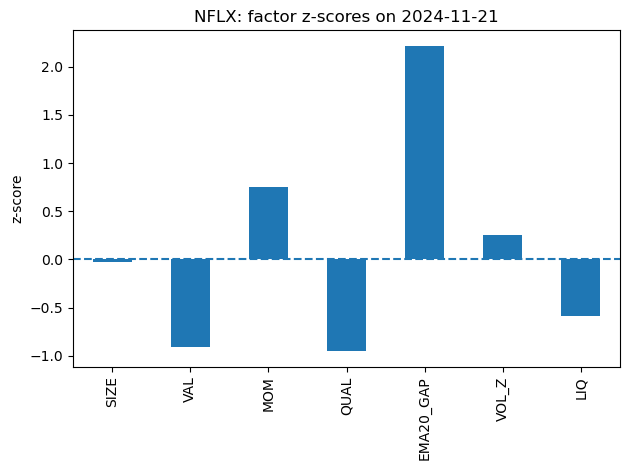

In [ ]:
plt.figure()
exposures.plot(kind="bar")
plt.axhline(0.0, linestyle="--")
plt.ylabel("z-score")
plt.title(f"{TICKER}: factor z-scores on {latest_date.date()}")
plt.tight_layout()
plt.show()

In [45]:
# 8. Decomposition of NFLX’s expected return (by factor)

beta_cols   = STYLE_COLS                  # typically ["SIZE","VAL","MOM","QUAL","EMA20_GAP","VOL_Z","LIQ"]
lambda_cols = [f"{c}_lambda" for c in STYLE_COLS]

beta_vals = row[beta_cols].values
lambda_vals = row[lambda_cols].values

contrib_vals = beta_vals * lambda_vals
contrib = pd.Series(contrib_vals, index=beta_cols, name="contrib")

print("Sum contrib vs μ_factor:")
print(contrib.sum(), " vs ", row["mu_factor"])

contrib.sort_values()


Sum contrib vs μ_factor:
0.010621367028050683  vs  0.010621367028050683


VAL         -0.000552
MOM          -0.00005
SIZE        -0.000024
VOL_Z        0.000036
QUAL         0.000211
LIQ          0.000486
EMA20_GAP    0.010516
Name: contrib, dtype: object

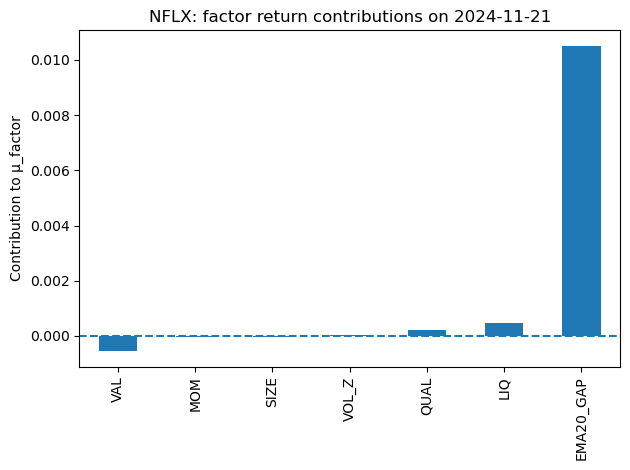

In [46]:
plt.figure()
contrib.sort_values().plot(kind="bar")
plt.axhline(0.0, linestyle="--")
plt.ylabel("Contribution to μ_factor")
plt.title(f"{TICKER}: factor return contributions on {latest_date.date()}")
plt.tight_layout()
plt.show()


In [ ]:
#----------------------------------------------------------------------------------